In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2 as cv

from PIL import Image
from tensorflow import keras
import tensorflow.keras.layers as k

from tensorflow import keras

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.utils import load_img


In [4]:
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(102)

In [5]:
image_dir = 'cell_images/'
size      = 64
dataset   = []
label    = []

In [6]:
parasitized_img = os.listdir(image_dir+"Parasitized/")

for i, img_name in enumerate(tqdm(parasitized_img)):
    if (img_name.split(".")[1] == "png"):
        image = cv.imread(image_dir+"Parasitized/"+img_name)
        image = Image.fromarray(image,"RGB")
        image = image.resize((size,size))
        
        dataset.append(np.array(image))
        label.append(0)

  0%|          | 0/4516 [00:00<?, ?it/s]

In [7]:
uninfected_img = os.listdir(image_dir+"Uninfected/")

for i, img_name in enumerate(tqdm(uninfected_img)):
    if (img_name.split(".")[1] == "png"):
        image = cv.imread(image_dir+"Uninfected/"+img_name)
        image = Image.fromarray(image,"RGB")
        image = image.resize((size,size))
        
        dataset.append(np.array(image))
        label.append(1)

  0%|          | 0/8820 [00:00<?, ?it/s]

In [8]:
from sklearn.model_selection import train_test_split
cafrom keras.utils import to_categorical

xtrain, xtest, ytrain, ytest = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.2,random_state = 102)

In [9]:
INPUT_SHAPE = (size, size, 3)

inp = k.Input(shape = INPUT_SHAPE)


#Convolution(1)
conv1 = k.Conv2D(32, kernel_size = (3,3),activation = "relu", padding = "same")(inp)
pool1 = k.MaxPool2D(pool_size = (2,2))(conv1)
norm1 = k.BatchNormalization(axis = -1)(pool1)
drop1 = k.Dropout(rate = 0.2)(norm1)

#Convolution(2)
conv2 = k.Conv2D(32, kernel_size = (3,3),activation = "relu", padding = "same")(drop1)
pool2 = k.MaxPool2D(pool_size = (2,2))(conv2)
norm2 = k.BatchNormalization(axis = -1)(pool2)
drop2 = k.Dropout(rate = 0.2)(norm2)

flat = k.Flatten()(drop2)

# Hidden(1)
hidden1 = k.Dense(512, activation="relu")(flat)
norm3 = k.BatchNormalization(axis = -1)(hidden1)
drop3 = k.Dropout(rate = 0.2)(norm3)

# Hidden(2)
hidden2 = k.Dense(512, activation="relu")(drop3)
norm4 = k.BatchNormalization(axis = -1)(hidden2)
drop4 = k.Dropout(rate = 0.2)(norm4)

out = k.Dense(2, activation = "sigmoid")(drop4)


In [10]:
model = keras.Model(inputs = inp, outputs = out)
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics = ["accuracy"])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [11]:
history = model.fit(np.array(xtrain), ytrain, batch_size = 64, verbose = 1, epochs = 15, validation_split = 0.1, shuffle = False)


Epoch 1/15
151/151 [==============================] - 30s 182ms/step - loss: 0.5554 - accuracy: 0.7799 - val_loss: 0.9586 - val_accuracy: 0.7563
Epoch 2/15
151/151 [==============================] - 26s 170ms/step - loss: 0.2500 - accuracy: 0.9139 - val_loss: 0.8222 - val_accuracy: 0.8585
Epoch 3/15
151/151 [==============================] - 25s 166ms/step - loss: 0.2041 - accuracy: 0.9299 - val_loss: 0.3228 - val_accuracy: 0.9091
Epoch 4/15
151/151 [==============================] - 26s 170ms/step - loss: 0.1792 - accuracy: 0.9382 - val_loss: 0.3902 - val_accuracy: 0.9185
Epoch 5/15
151/151 [==============================] - 26s 171ms/step - loss: 0.1531 - accuracy: 0.9482 - val_loss: 0.3581 - val_accuracy: 0.9147
Epoch 6/15
151/151 [==============================] - 26s 175ms/step - loss: 0.1283 - accuracy: 0.9539 - val_loss: 0.3571 - val_accuracy: 0.9091
Epoch 7/15
151/151 [==============================] - 28s 186ms/step - loss: 0.1158 - accuracy: 0.9604 - val_loss: 0.4363 - val_ac

In [12]:
print("Test Accuracy : {: .2f}%".format(model.evaluate(np.array(xtest),np.array(ytest))[1]*100))


84/84 [==============================] - 2s 21ms/step - loss: 0.5341 - accuracy: 0.9187
Test Accuracy :  91.87%


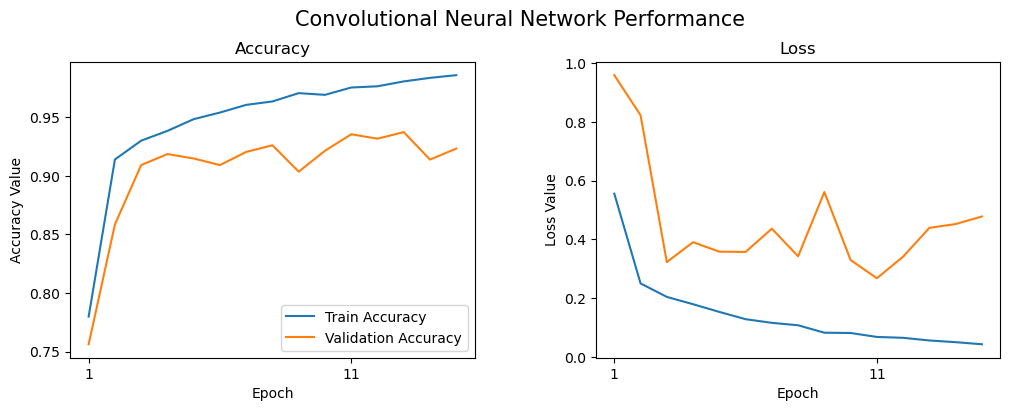

In [13]:
f, (ax1,ax2) = plt.subplots(1,2,figsize = (12,4))
t = f.suptitle("Convolutional Neural Network Performance", fontsize = 15)
f.subplots_adjust(top = 0.85, wspace = 0.3)

max_epoch = len(history.history["accuracy"])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history["accuracy"],label ="Train Accuracy")
ax1.plot(epoch_list,history.history["val_accuracy"],label = "Validation Accuracy")

ax1.set_xticks(np.arange(1, max_epoch,10))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history["loss"],label ="Train Loss")
ax2.plot(epoch_list,history.history["val_loss"],label = "Validation Loss")

ax2.set_xticks(np.arange(1, max_epoch,10))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax1.legend(loc="best")


In [18]:
import cv2

In [27]:
test_img = cv2.imread('tst1.png')

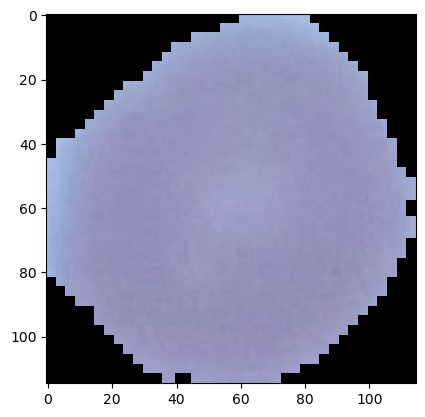

In [28]:
plt.imshow(test_img)

In [29]:
test_img = cv2.resize(test_img,(64,64))

In [30]:
test_input = test_img.reshape((1,64,64,3))

In [31]:
pred = model.predict(test_input)

1/1 [==============================] - 0s 35ms/step


In [32]:
print(pred)

[[0.00787186 0.9851574 ]]


In [33]:
threshold = 0.5
binary_predictions = (pred >= threshold).astype(int)
print(binary_predictions)


[[0 1]]
